# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

#### Import libraries

In [40]:
import timeit
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import sys

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import set_config

sys.modules['sklearn.externals.joblib'] = joblib
set_config(display="diagram")

#### Import the data into a pandas DataFrame

In [41]:
vehicles_raw = pd.read_csv('data/vehicles.csv')

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### We are asked to find the correlation bertween the key features of the data and what combination of feratures values, our model parameters, will influenc the price of a car.  
#### What is our customer profile? Are they technical? Are they professionals, recriational? Dothey chose the car based on 1, 2, 3 or more features?
#### I looked at the data from 2 perspective of the ttarget audience, 1 and the obvious is all the data for general use and the other is from a specific dealer ship perspective.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

####  Our dataset contain 426880 samples of 18 features, including price, size, condition, make and model, year, odometer and more. These features could be used to calculate a price of a car. 
#### Most of the data features are categorical showing up as object data type.

In [42]:
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### There is segnificant number of data missing, NaN. only 34868 samples include the full scope, that is only 8.1% of the dataset

In [43]:
vehicles_raw.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [64]:
vehicles_raw.describe(include = ['object'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,131904,63465,87056,79285,50614


In [44]:
vehicles_raw_copy = vehicles_raw

In [45]:
vehicles_raw_copy.dropna()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy
426833,7302338378,wyoming,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,SAJGX2749VCOO8376,rwd,compact,convertible,white,wy


#### Just dropping the missing data is not good enough, we will have to selectively clean the data.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Step 1 - removing the id and VIN columns which are unique values and will not contribute much to our model

In [46]:
#vehicles_dp_s1 = data preperation step 1
vehicles_raw.drop(columns = ['id', 'VIN'], inplace = True)
vehicles_dp_s1 = vehicles_raw
vehicles_dp_s1.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

#### Step 2 - dropping null values

In [48]:
#vehicles_dp_s2 = data preperation step 2
vehicles_dp_s2 = vehicles_dp_s1.dropna()
vehicles_dp_s2.shape

(79195, 16)

#### Step 3 - Target Encoding

In [49]:
from category_encoders.target_encoder import TargetEncoder

In [50]:
target_encoder = TargetEncoder()

In [54]:
#vehicles_dp_s3 = data preperation step 3
vehicles_dp_s3=vehicles_dp_s2.copy()
for col in vehicles_dp_s3.select_dtypes(include='O').columns:
    vehicles_dp_s3[col] = \
    target_encoder.fit_transform(vehicles_dp_s3[col],vehicles_dp_s3.price)
    
vehicles_dp_s3

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
31,57917.150958,15000,2013.0,87922.764744,19454.462673,108462.551441,17017.914351,68842.299115,128000.0,83377.677283,85714.437478,77723.372850,134951.499489,31550.787389,24378.009363,15456.921929
55,57917.150958,19900,2004.0,87922.764744,21005.819449,55362.418167,231330.783661,236076.140092,88000.0,83377.677283,85714.437478,137035.579488,134951.499489,773008.850742,11203.370049,15456.921929
59,57917.150958,14000,2012.0,8603.773748,8604.824373,108462.551441,17017.914351,68842.299115,95000.0,83377.677283,85714.437478,12373.205114,134951.499489,8828.418417,336037.642932,15456.921929
65,57917.150958,22500,2001.0,87922.764744,36155.067615,55362.418167,231330.783661,236076.140092,144700.0,83377.677283,12047.265649,77723.372850,134951.499489,31550.787389,79825.903414,15456.921929
73,57917.150958,15000,2017.0,10512.352430,71049.492003,108462.551441,231330.783661,68842.299115,90000.0,20181.155984,85714.437478,77723.372850,10499.790046,13896.394391,26844.123002,15456.921929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,18865.656288,18000,2005.0,14755.205592,25628.514038,108462.551441,231330.783661,68842.299115,130000.0,22082.020498,85714.437478,137035.579488,134951.499489,31550.787389,11203.370049,18865.656288
426809,18865.656288,18000,1990.0,13806.465920,71439.817426,55362.418167,231330.783661,68842.299115,114400.0,83377.677283,85714.437478,137035.579488,134951.499489,12332.484260,24378.009363,18865.656288
426831,18865.656288,9800,1985.0,43205.959168,63972.159663,43094.119966,17017.914351,68842.299115,115000.0,83377.677283,85714.437478,77723.372850,9111.535714,8180.330997,12632.860861,18865.656288
426833,18865.656288,6800,1997.0,14335.143719,65270.948111,55362.418167,231330.783661,68842.299115,69550.0,83377.677283,85714.437478,77723.372850,8617.999702,15054.628982,79825.903414,18865.656288


#### Step 4 - converting data types and final removal of 0 values at the price feature

In [55]:
#vehicles_dp_s4 = data preperation step 4

# convert data types
vehicles_dp_s4 = vehicles_dp_s3.convert_dtypes()

# removing the 0 values form the 'price' column
# I'v decided to leave the odometer 0 values as it make sense that cars have not been driven but up for sale
vehicles_dp_s4 = vehicles_dp_s4[vehicles_dp_s4['price'] != 0]


vehicles_dp_s4.shape

(75738, 16)

In [65]:
vehicles_dp_s4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75738 entries, 31 to 426833
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   region        75738 non-null  int64
 1   price         75738 non-null  Int64
 2   year          75738 non-null  Int64
 3   manufacturer  75738 non-null  int64
 4   model         75738 non-null  int64
 5   condition     75738 non-null  int64
 6   cylinders     75738 non-null  int64
 7   fuel          75738 non-null  int64
 8   odometer      75738 non-null  Int64
 9   title_status  75738 non-null  int64
 10  transmission  75738 non-null  int64
 11  drive         75738 non-null  int64
 12  size          75738 non-null  int64
 13  type          75738 non-null  int64
 14  paint_color   75738 non-null  int64
 15  state         75738 non-null  int64
dtypes: Int64(3), int64(13)
memory usage: 12.1 MB


In [66]:
vehicles_dp_s4[vehicles_dp_s4.select_dtypes(include=['float']).columns] = vehicles_dp_s4.select_dtypes(include=['float']).astype('int64')
vehicles_dp_s4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75738 entries, 31 to 426833
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   region        75738 non-null  int64
 1   price         75738 non-null  Int64
 2   year          75738 non-null  Int64
 3   manufacturer  75738 non-null  int64
 4   model         75738 non-null  int64
 5   condition     75738 non-null  int64
 6   cylinders     75738 non-null  int64
 7   fuel          75738 non-null  int64
 8   odometer      75738 non-null  Int64
 9   title_status  75738 non-null  int64
 10  transmission  75738 non-null  int64
 11  drive         75738 non-null  int64
 12  size          75738 non-null  int64
 13  type          75738 non-null  int64
 14  paint_color   75738 non-null  int64
 15  state         75738 non-null  int64
dtypes: Int64(3), int64(13)
memory usage: 12.1 MB


#### Our data now consist of 75,738 samples of 16 features.

In [70]:
vehicles_4_model = vehicles_dp_s4

In [71]:
vehicles_4_model.reset_index()

,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,31,57917,15000,2013,87922,19454,108462,17017,68842,128000,83377,85714,77723,134951,31550,24378,15456
1,55,57917,19900,2004,87922,21005,55362,231330,236076,88000,83377,85714,137035,134951,773008,11203,15456
2,59,57917,14000,2012,8603,8604,108462,17017,68842,95000,83377,85714,12373,134951,8828,336037,15456
3,65,57917,22500,2001,87922,36155,55362,231330,236076,144700,83377,12047,77723,134951,31550,79825,15456
4,73,57917,15000,2017,10512,71049,108462,231330,68842,90000,20181,85714,77723,10499,13896,26844,15456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75733,426793,18865,15999,2018,14755,67532,108462,9332,68842,36465,83377,85714,12373,10499,13896,24378,18865
75734,426808,18865,18000,2005,14755,25628,108462,231330,68842,130000,22082,85714,137035,134951,31550,11203,18865
75735,426809,18865,18000,1990,13806,71439,55362,231330,68842,114400,83377,85714,137035,134951,12332,24378,18865
75736,426831,18865,9800,1985,43205,63972,43094,17017,68842,115000,83377,85714,77723,9111,8180,12632,18865


In [72]:
vehicles_4_model.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
31,57917,15000,2013,87922,19454,108462,17017,68842,128000,83377,85714,77723,134951,31550,24378,15456
55,57917,19900,2004,87922,21005,55362,231330,236076,88000,83377,85714,137035,134951,773008,11203,15456
59,57917,14000,2012,8603,8604,108462,17017,68842,95000,83377,85714,12373,134951,8828,336037,15456
65,57917,22500,2001,87922,36155,55362,231330,236076,144700,83377,12047,77723,134951,31550,79825,15456
73,57917,15000,2017,10512,71049,108462,231330,68842,90000,20181,85714,77723,10499,13896,26844,15456


In [73]:
vehicles_4_model.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
426793,18865,15999,2018,14755,67532,108462,9332,68842,36465,83377,85714,12373,10499,13896,24378,18865
426808,18865,18000,2005,14755,25628,108462,231330,68842,130000,22082,85714,137035,134951,31550,11203,18865
426809,18865,18000,1990,13806,71439,55362,231330,68842,114400,83377,85714,137035,134951,12332,24378,18865
426831,18865,9800,1985,43205,63972,43094,17017,68842,115000,83377,85714,77723,9111,8180,12632,18865
426833,18865,6800,1997,14335,65270,55362,231330,68842,69550,83377,85714,77723,8617,15054,79825,18865


#### Pre modeling data review, correlations

In [74]:
vehicles_4_model.corr()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
region,1.000000,0.055665,-0.009181,0.024839,0.005250,0.009104,-0.013389,0.010401,0.011442,-0.004870,-0.015270,-0.004215,-0.010423,0.015139,0.010716,0.385869
price,0.055665,1.000000,-0.001443,0.010976,0.085953,0.002254,0.007421,0.003200,0.000809,0.001193,0.001551,0.004070,0.004550,0.015364,0.008018,0.020310
year,-0.009181,-0.001443,1.000000,0.005828,-0.002041,0.108873,-0.212946,0.018398,-0.119279,-0.052431,0.219710,0.005573,-0.022112,-0.056580,0.070486,-0.027353
manufacturer,0.024839,0.010976,0.005828,1.000000,0.154582,0.014062,-0.077911,-0.063056,0.023523,0.005583,0.025895,-0.062615,-0.026400,0.026247,0.026851,0.015891
model,0.005250,0.085953,-0.002041,0.154582,1.000000,-0.002213,0.082665,0.020434,0.007418,0.000859,0.010689,0.040143,0.045112,0.044418,-0.000835,0.009056
condition,0.009104,0.002254,0.108873,0.014062,-0.002213,1.000000,-0.037337,-0.013510,-0.049136,0.034592,0.021313,0.014476,-0.035457,0.018308,0.023003,0.016667
cylinders,-0.013389,0.007421,-0.212946,-0.077911,0.082665,-0.037337,1.000000,0.213873,0.035345,0.049667,0.059472,0.374649,0.426330,0.274754,-0.064008,-0.027674
fuel,0.010401,0.003200,0.018398,-0.063056,0.020434,-0.013510,0.213873,1.000000,0.025218,0.009841,0.002302,0.200763,0.215821,0.170508,-0.026975,0.004052
odometer,0.011442,0.000809,-0.119279,0.023523,0.007418,-0.049136,0.035345,0.025218,1.000000,0.024979,-0.016279,0.011982,0.024971,0.030689,0.001479,0.008254
title_status,-0.004870,0.001193,-0.052431,0.005583,0.000859,0.034592,0.049667,0.009841,0.024979,1.000000,0.003019,0.025110,0.035748,0.004418,0.003571,0.002525


<AxesSubplot:>

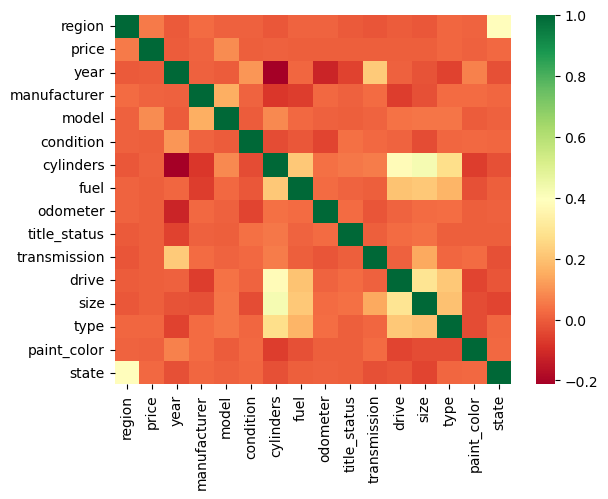

In [75]:
sns.heatmap(vehicles_4_model.corr(), annot = False, cmap = "RdYlGn")

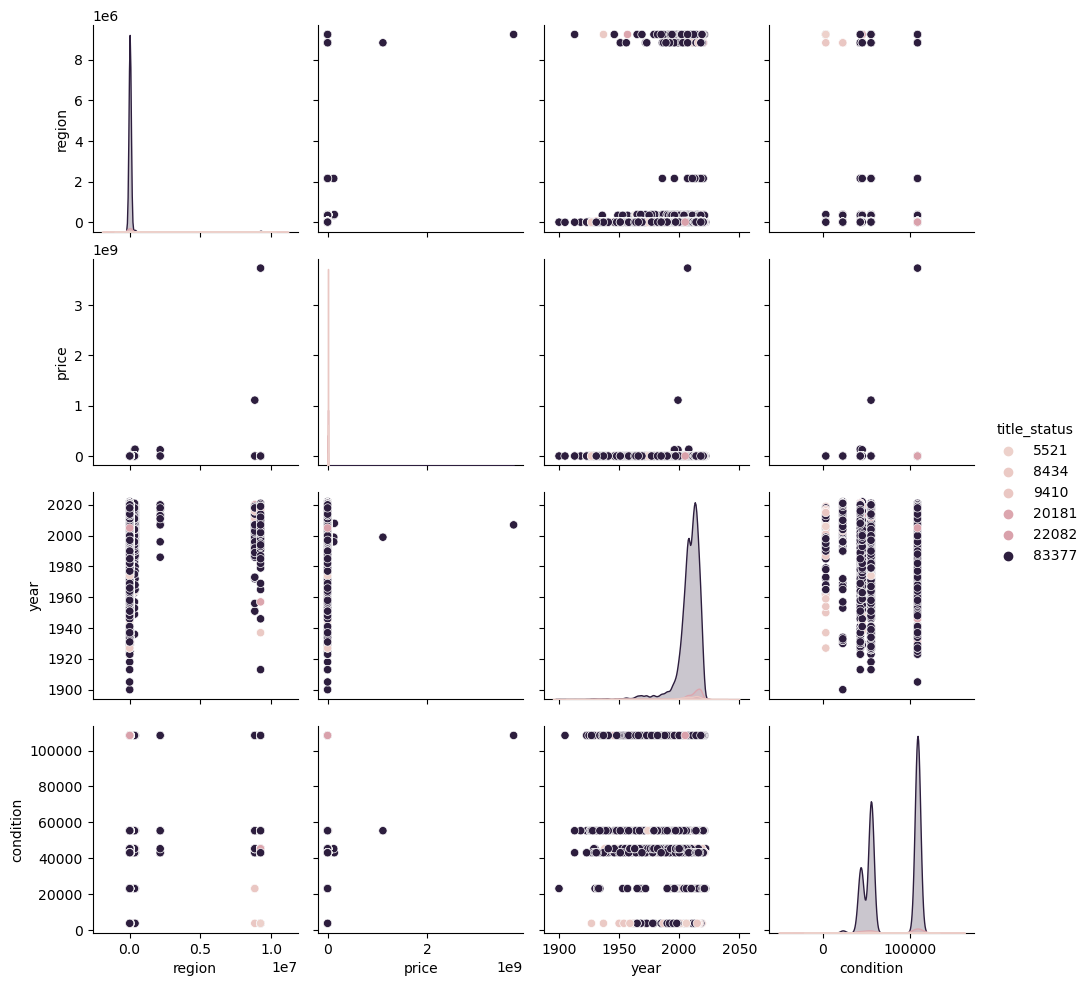

In [76]:
sns.pairplot(data = vehicles_4_model, vars = \
             vehicles_4_model[['region','price','year','condition']], hue = 'title_status')
plt.show()

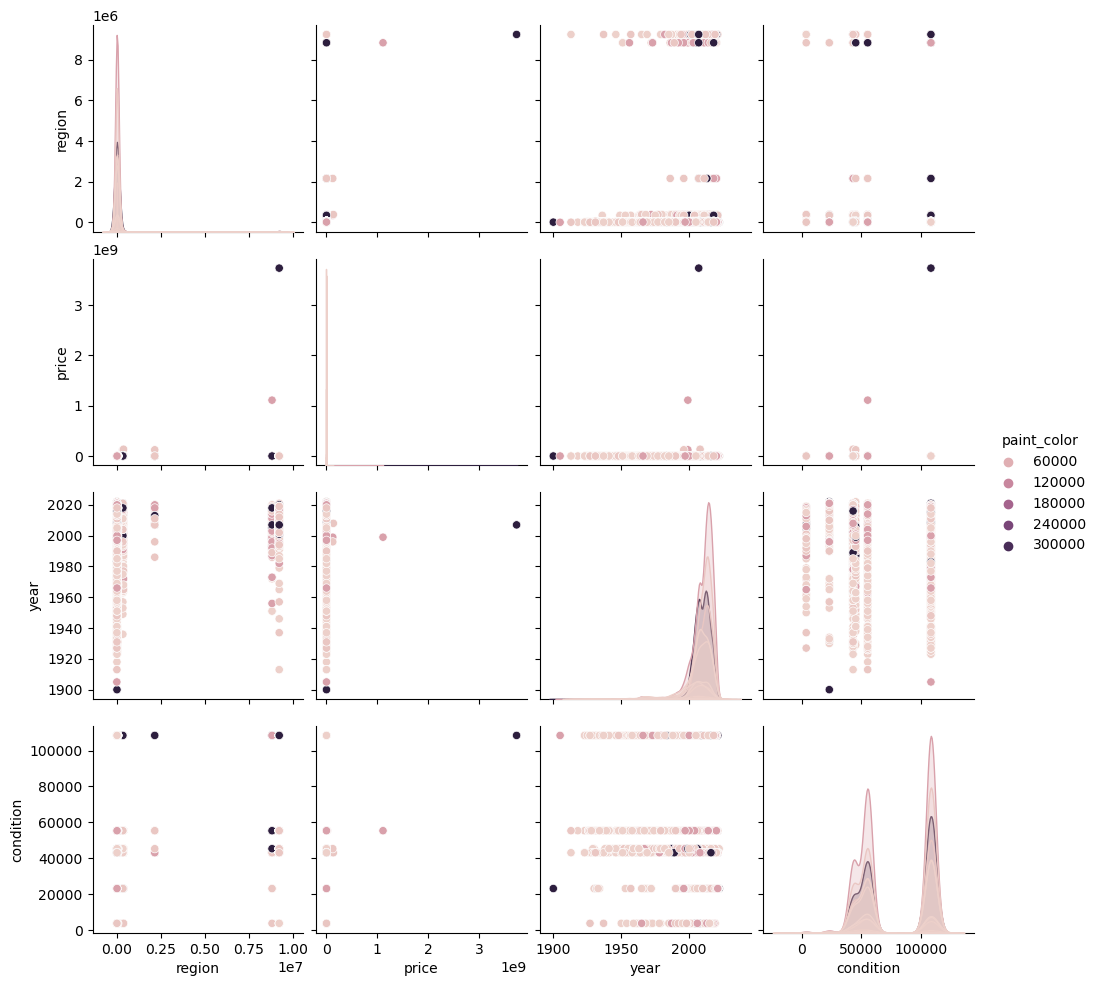

In [63]:
sns.pairplot(data = vehicles_4_model, vars = \
             vehicles_4_model[['region','price','year','condition']], hue = 'paint_color')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.